In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

# Step-1

# Reading Data

In [ ]:
patient_data=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

In [ ]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


* Here we have Patient Ids and Disease info
  

> Lets check out what is in annoted '.txt' files of audio files.

In [ ]:
df=pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


* These are very usefull information namely (Start , End ( time of respiratory cycles) ,crackles,weezels)

> So lets get them into a dataset

> Note:- i use sep **' \t '** cause we are reading data from text file which is sperated by tabs here

In [ ]:
import os
path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['168_1b1_Al_sc_Meditron',
 '172_1b4_Ar_mc_AKGC417L',
 '130_3p2_Pr_mc_AKGC417L',
 '177_2b4_Pl_mc_AKGC417L',
 '130_2p5_Pl_mc_AKGC417L']

> As mentioned in **filename_format.txt** , '.txt' files of annotated audio files have various information. So we will try to extract that too.  

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

> Here useful info  is [Patient ID, __ ,__ ,Type(mono,stereo), __ ]

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.036,2.436,0,0,168,sc,168_1b1_Al_sc_Meditron
1,2.436,5.250,0,0,168,sc,168_1b1_Al_sc_Meditron
2,5.250,8.422,0,0,168,sc,168_1b1_Al_sc_Meditron
3,8.422,11.222,0,0,168,sc,168_1b1_Al_sc_Meditron
4,11.222,13.807,0,0,168,sc,168_1b1_Al_sc_Meditron


> Now we can join both **patient_data** and **files_df**

In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 2
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


> Lets get **pid** and **101** to same type and merge both dataframes on pid

In [ ]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.036,2.436,0,0,168,sc,168_1b1_Al_sc_Meditron,Bronchiectasis
1,2.436,5.250,0,0,168,sc,168_1b1_Al_sc_Meditron,Bronchiectasis
2,5.250,8.422,0,0,168,sc,168_1b1_Al_sc_Meditron,Bronchiectasis
3,8.422,11.222,0,0,168,sc,168_1b1_Al_sc_Meditron,Bronchiectasis
4,11.222,13.807,0,0,168,sc,168_1b1_Al_sc_Meditron,Bronchiectasis


In [ ]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

# Step 2

# Processing Audio files

> Now we only want that parts from whole audio file which contains **Respiratory Cycles**

> We can do this by utilizing the start and end time specifiles for these cycles in our **data dataframe**

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args

    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo

    '''
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

* we multiplied start with sampling rate cause start is time and raw_data is array sampled acc. to sampling rate

> Now we also want our input images to our cnn to be of same size for that audio files must be of **same length** i.e **(start - end)** must be same

> Lets find the best length we can have

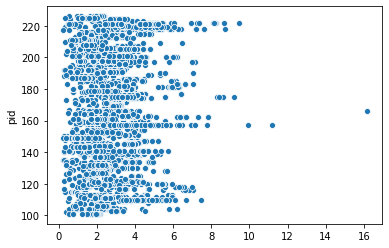

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

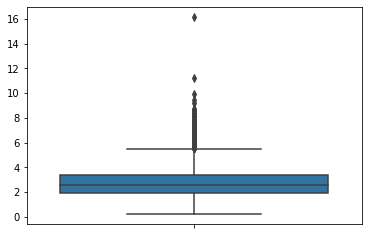

In [ ]:
sns.boxplot(y=(data.end-data.start))

+ From these plots, we can conclude that the best length is approximately 6. Additionally, if the difference is less than 6, we must Zero Pad it to reach the required length.

+ Zero Padding effectively means adding silence to reach the desired length.


In [ ]:
# Lets create a directory for storing our files
os.makedirs('processed_audio_files')

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.036
end                          2.436
crackles                         0
weezels                          0
pid                            168
mode                            sc
filename    168_1b1_Al_sc_Meditron
disease             Bronchiectasis
Name: 0, dtype: object


A single sample audio file can contain many respiratory cycles, so we might need to save multiple files from a single audio file using the Librosa module for loading and the Soundfile module for writing to the output path.

In [ ]:
import librosa as lb
import soundfile as sf
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']

    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen

    audio_file_loc=path + filename + '.wav'

    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'

    save_path='processed_audio_files/' + filename
    c+=1

    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)

    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)

    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)